In [1]:
from analyze import Analysis
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
OUTPUT_PATH = os.path.join("./output", "2024-12-20-02-14-04")
DATA_PATH = os.path.join("./data", "2024-12-19-16-09-00")
SEED = 42

In [3]:
log_path = os.path.join(OUTPUT_PATH, "run.log")
pattern = re.compile(
    r"Embedding Prefix: (.+?)\n.*?Param_Grid: (.+?)\n.*?Best params: (.+?)\n.*?Best score: ([0-9.]+)"
)
classfications = list(Analysis.ALGORITHMS.keys())

extracted_info = []

with open(log_path, "r") as f:
    log_content = f.read()
    matches = pattern.findall(log_content)

    for idx, match in enumerate(matches):
        prefix, _, _, best_score = match
        extracted_info.append(
            {
                "Embedding": prefix.strip(),
                "Classifier": classfications[idx % len(classfications)],
                "Accuracy": float(best_score.strip()),
            }
        )

df_params = pd.DataFrame(extracted_info)
df_params


,Embedding,Classifier,Accuracy
0,word2vec_cbow,SVM,0.50752
1,word2vec_cbow,LR,0.50752
2,word2vec_cbow,RF,0.50828
3,word2vec_skipgram,SVM,0.50748
4,word2vec_skipgram,LR,0.50752
5,word2vec_skipgram,RF,0.50820
6,word2vec_pretrained,SVM,0.83904
7,word2vec_pretrained,LR,0.83316
8,word2vec_pretrained,RF,0.79700


In [4]:
df_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, "report.csv"))
df_metrics["macro avg"] = pd.to_numeric(df_metrics["macro avg"], errors="coerce")
filtered_df_metrics = df_metrics[df_metrics["macro avg"] < 1]["macro avg"]
reshaped_array = filtered_df_metrics.values.reshape(-1, 3)
reshaped_df_metrics = pd.DataFrame(
    reshaped_array, columns=["Precision", "Recall", "F1-score"]
)
reshaped_df_metrics

,Precision,Recall,F1-score
0,0.514067,0.50380,0.393053
1,0.513306,0.50212,0.369639
2,0.522328,0.50280,0.363666
3,0.528809,0.50532,0.378672
4,0.517323,0.50352,0.380019
5,0.494363,0.49952,0.351110
6,0.781137,0.78088,0.780830
7,0.780619,0.78048,0.780453
8,0.768648,0.76856,0.768541


In [5]:
concated_df = pd.concat([df_params, reshaped_df_metrics], axis=1)
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
concated_df

,Embedding,Classifier,Accuracy,Precision,Recall,F1-score
0,word2vec_cbow,SVM,0.50752,0.514067,0.50380,0.393053
1,word2vec_cbow,LR,0.50752,0.513306,0.50212,0.369639
2,word2vec_cbow,RF,0.50828,0.522328,0.50280,0.363666
3,word2vec_skipgram,SVM,0.50748,0.528809,0.50532,0.378672
4,word2vec_skipgram,LR,0.50752,0.517323,0.50352,0.380019
5,word2vec_skipgram,RF,0.50820,0.494363,0.49952,0.351110
6,word2vec_pretrained,SVM,0.83904,0.781137,0.78088,0.780830
7,word2vec_pretrained,LR,0.83316,0.780619,0.78048,0.780453
8,word2vec_pretrained,RF,0.79700,0.768648,0.76856,0.768541


In [6]:
pca = PCA(n_components=2, random_state=42)
pattern = r"^(\w+[-\w]+)_"


def plot_pca(mode: str) -> None:
    npy_paths = sorted(glob.glob(os.path.join(OUTPUT_PATH, f"**_{mode}.npy")))
    df_sentiment = pd.read_csv(
        os.path.join(DATA_PATH, f"{mode}.csv"), usecols=["sentiment"]
    )

    _, axes = plt.subplots(1, len(npy_paths), figsize=(15, 5))

    for ax, npy_path in zip(axes, npy_paths):
        array = pca.fit_transform(np.load(npy_path))
        v2d_df = pd.DataFrame(array, columns=["Dim1", "Dim2"])
        concated_df = pd.concat([v2d_df, df_sentiment], axis=1)

        sns.scatterplot(
            x="Dim1",
            y="Dim2",
            hue="sentiment",
            data=concated_df,
            palette="seismic",
            alpha=0.5,
            ax=ax,
        )

        title = re.search(pattern, os.path.basename(npy_path)).group(1)
        ax.set_title(title)
    
    plt.show()

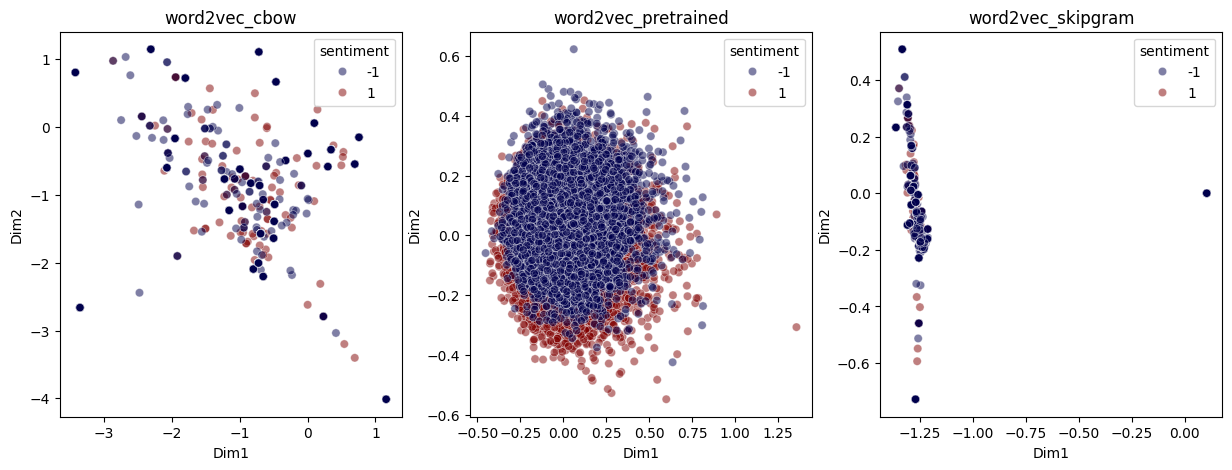

In [7]:
plot_pca("train")

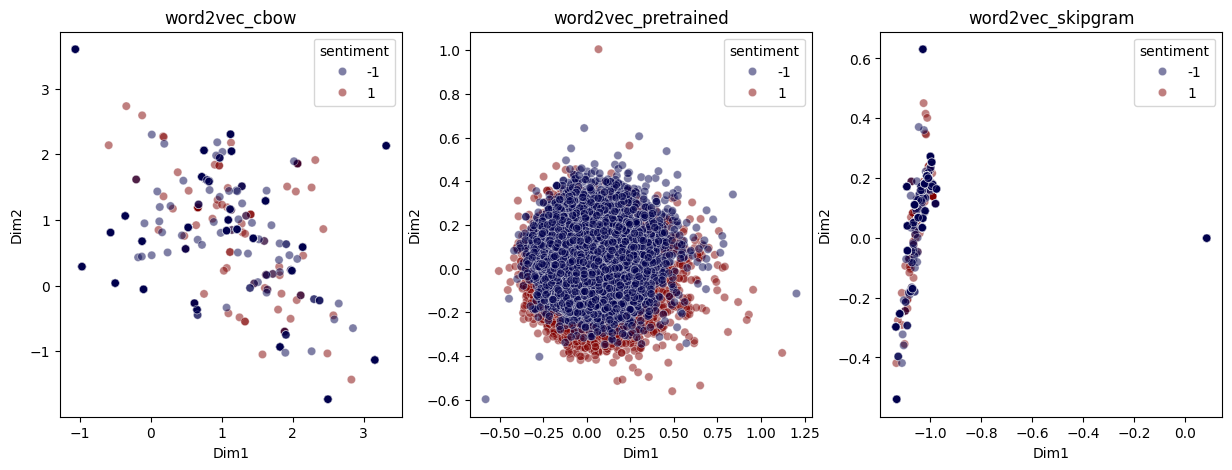

In [8]:
plot_pca("test")

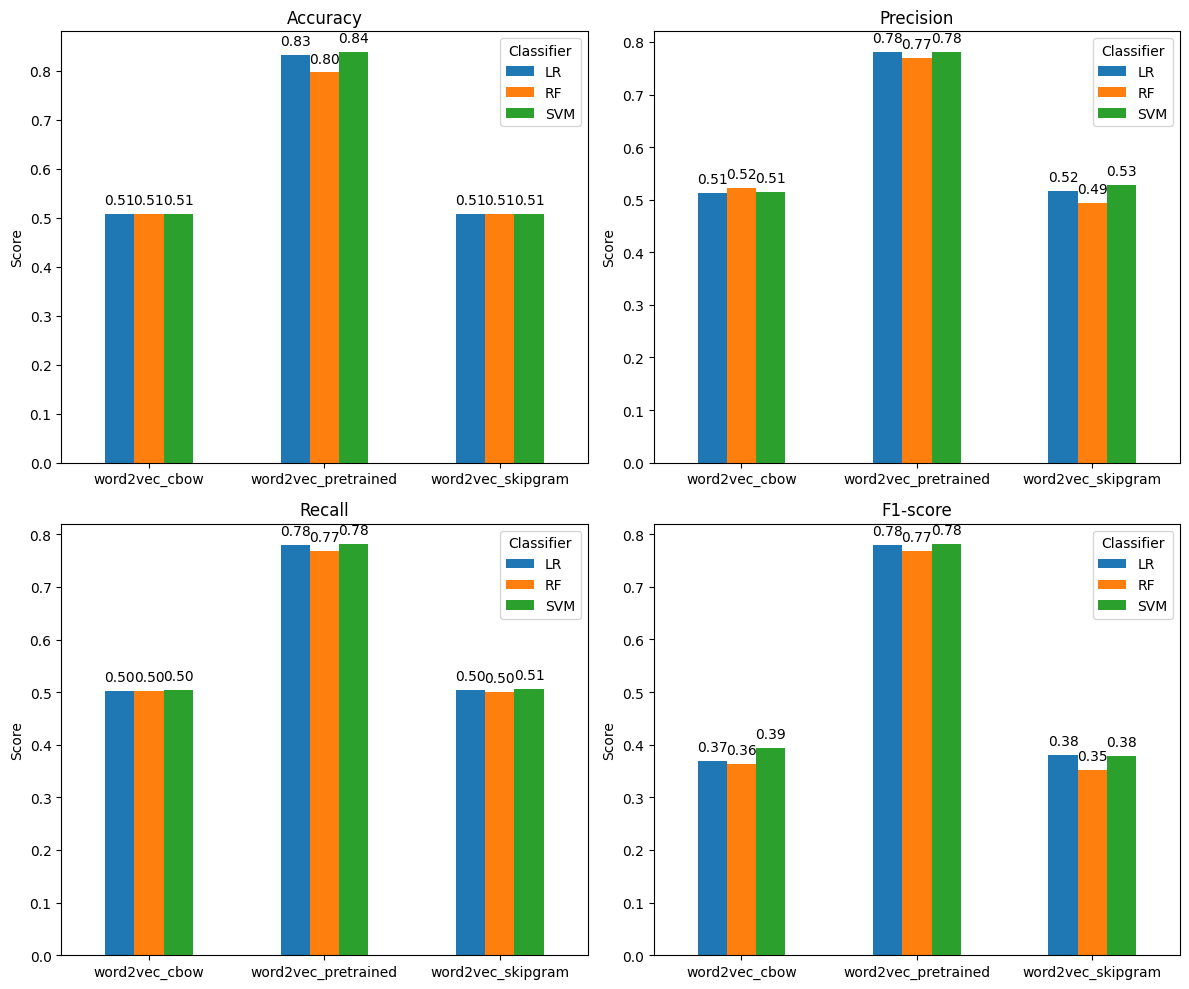

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, metric in zip(axes.flatten(), metrics):
    pivot_table = concated_df.pivot(
        index="Embedding", columns="Classifier", values=metric
    )
    pivot_table.plot(kind="bar", ax=ax)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.set_title(metric.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("Score")
    ax.set_xticklabels(pivot_table.index, rotation=0)


plt.tight_layout()
plt.show()
